# Reversible Network Reconnection Model

Attempt at implementing the RNR model as described in Okuda et al. 2012:

>_Reversible network reconnection model for simulating large deformation in dynamic tissue morphogenesis_, Satoru Okuda, Yasuhiro Inoue, Mototsugu Eiraku, Yoshiki Sasai and Taiji Adachi Biomech Model Mechanobiol (2013) 12:627–644 [DOI 10.1007/s10237-012-0430-7](http://link.springer.com/article/10.1007%2Fs10237-012-0430-7)


The authors give 4 conditions which we detail and implement bellow.




## Condition 1 - Center of a face

The center of a face is defined by the average position of the face's edges midpoints, weighted by their lengths.

$$ \mathbf{r}_{\alpha} = \frac{\sum_{ij\alpha}\ell_{ij} (\mathbf{r}_i + \mathbf{r}_j)/2}{\sum_{ij\alpha}\ell_{ij}}$$


In [1]:
import numpy as np, pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline

from tyssue import Epithelium
from tyssue import BulkGeometry
from tyssue import Sheet
from tyssue.config.geometry import bulk_spec
from tyssue.utils.utils import _to_3d 
from tyssue.core.generation import three_faces_sheet
from tyssue.core.generation import extrude
from tyssue.draw.threejs_draw import view_3js
from tyssue.draw.plt_draw import quick_edge_draw
from tyssue.topology.bulk_topology import IH_transition, HI_transition

    
class RNRGeometry(BulkGeometry):
    
    @staticmethod
    def update_centroid(eptm):

        srce_pos = eptm.upcast_srce(eptm.vert_df[eptm.coords])
        trgt_pos = eptm.upcast_trgt(eptm.vert_df[eptm.coords])
        mid_pos = (srce_pos + trgt_pos)/2
        
        eptm.face_df[eptm.coords] = (eptm.sum_face(mid_pos * _to_3d(eptm.edge_df['length'])).values /
                                     eptm.face_df['perimeter'].values[:, np.newaxis])
        srce_pos['cell'] = eptm.edge_df['cell']
        eptm.cell_df[eptm.coords] = srce_pos.groupby('cell').mean()

sheet = Sheet.planar_sheet_3d('sheet', 5, 5, 1, 1)
sheet.sanitize()
datasets = extrude(sheet.datasets, method='translation')

eptm = Epithelium('20faces_3D', datasets, bulk_spec())
RNRGeometry.update_all(eptm)
RNRGeometry.center(eptm)


eptm.settings['threshold_length'] = 1e-4
print(eptm.Nf, eptm.Ne, eptm.Nv)

render, line = view_3js(eptm)
display(render)

93 414 70


## I→H transition

![IH transition in a bulk and a monolayer](../data/png/IH_transition.png)



In [2]:
e_1011 = 26
eptm.settings['threshold_length'] = 1

IH_transition(eptm, e_1011)
RNRGeometry.update_all(eptm)


render, line = view_3js(eptm)
display(render)

# H → I transition

In [3]:
fa = 93

HI_transition(eptm, fa)
RNRGeometry.update_all(eptm)

render, line = view_3js(eptm)
display(render)

### Testing for I→H / H →I transition triggers

In [4]:
eptm.settings['threshold_length'] = 1e-3

In [5]:
def find_rearangements(eptm):
    l_th = eptm.settings['threshold_length']
    up_num_sides = eptm.upcast_face(eptm.face_df['num_sides'])   
    shorts = eptm.edge_df[eptm.edge_df['length'] < l_th]
    non_triangular = up_num_sides[up_num_sides > 4 ].index
    edges_IH = set(shorts.index).intersection(non_triangular)

    max_f_length = shorts.groupby('face')['length'].apply(max)
    short_faces = max_f_length[max_f_length < l_th].index
    three_faces = eptm.face_df[eptm.face_df['num_sides'] == 3].index
    faces_HI = set(three_faces).intersection(short_faces)
    return edges_IH, faces_HI

find_rearangements(eptm)

(set(), set())

### Condition 3

This condition is satisfied if `eptm.settings['threshold_length']`
is well defined, i.e, small with respect to the unit length or the
average edge length.

### Condition 4

* (i)  Two edges never share two vertices simultaneously.

_In our half-edge architecture, this is not as straight forward. But I think the condition can
be reformulated as:_ Two edges **from the same face** never share two edges simultanously.
I don't know how to demonstrate this, but I think these are equivalent (to get two edges together, you need to "squeeze" one face between those two.

* (ii) Two polygonal faces never share two or more edges simultaneously.


In [6]:
from tyssue.topology.base_topology import condition_4i, condition_4ii

In [5]:
condition_4i(eptm), condition_4ii(eptm)

NameError: name 'condition_4i' is not defined

In [8]:
eptm.settings['threshold_length'] = 0.5

IH_transition(eptm, eptm.edge_df.index[-1])
RNRGeometry.update_all(eptm)

render, line = view_3js(eptm)
display(render)

In [9]:
invalid = eptm.get_invalid()
assert np.alltrue(1 - invalid)
assert np.alltrue(eptm.edge_df['sub_vol'] > 0)

In [10]:
%pdb

Automatic pdb calling has been turned ON


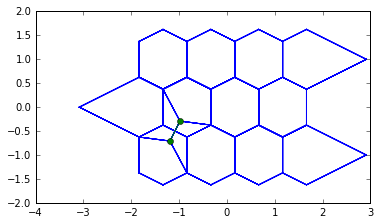

In [11]:
fig, ax = quick_edge_draw(eptm)
e_1011 = eptm.edge_df.index[-7]
vs_1011 = eptm.vert_df.loc[eptm.edge_df.loc[e_1011, ['srce', 'trgt']].values, eptm.coords]

ax.plot(vs_1011.x, vs_1011.y, '-o')

In [12]:
IH_transition(eptm, e_1011)
RNRGeometry.update_all(eptm)

render, line = view_3js(eptm)
display(render)

In [13]:
condition_4i(eptm)

Int64Index([], dtype='int64', name='face')

In [14]:
condition_4ii(eptm)

[frozenset({30, 31}), frozenset({42, 43})]